In [1]:
#-*- coding:utf-8 -*-
import numpy as np
import numpy.random as rd
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
seed = 0
rd.seed(seed)

In [3]:
#データ生成
cp = [200, 250, 200, 300] #変化点(changing_point)を指定
x1 = np.concatenate([rd.normal(0.7, 0.05, cp[0]),
                     rd.normal(1.5, 0.05, cp[1]),
                     rd.normal(0.6, 0.05, cp[2]),
                     rd.normal(1.3, 0.05, cp[3])])

x2 = np.concatenate([rd.normal(1.5, 0.05, cp[0]),
                     rd.normal(1.0, 0.05, cp[1]),
                     rd.normal(1.2, 0.05, cp[2]),
                     rd.normal(0.8, 0.05, cp[3])])

#結合
x = np.c_[x1, x2]

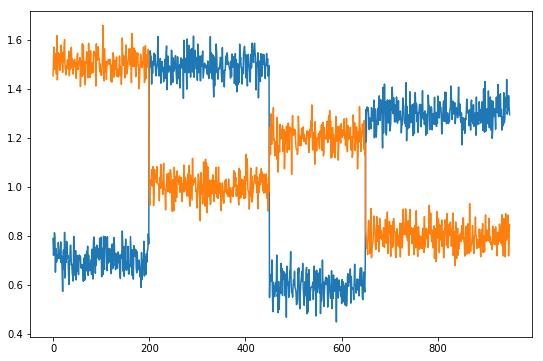

In [4]:
#可視化
plt.figure(figsize=(9, 6))
plt.plot(x1)
plt.plot(x2)

# SDAR

In [56]:
class SDAR():
    def __init__(self, k, r):
        '''
        '''
        # Given
        self.k = k # ARモデルの次数
        self.r = r #　忘却係数
        
        # 初期化
        self.mu_hat = None
        self.C = None
        self.omega_hat = None
        self.sigma_hat = None
        
        self.x = None # 入力されたデータ
        self.d = None #入力データの次元
        self.t = 1 # 時点
        
    def update(self, x_t):
        
        if self.t == 1:
            self.set_initial_params(x_t)
        
        self.add_new_index()
        
        # x_t を格納
        self.x[self.t] = x_t
        
        # μ^の更新
        self.mu_hat[self.t] = (1 - self.r) * self.mu_hat[self.t-1] + self.r * x_t
        
        
        for j in range(self.k+1):
            if self.t > j:
                self.C[self.t, j] = (1 - self.r) * self.C[self.t-1, j] + self.r \
                                * np.dot((x_t - self.mu_hat[self.t])[:, np.newaxis], (self.x[self.t-j] - self.mu_hat[self.t])[:, np.newaxis].T)
        
        
        if self.t > self.k:
            # Yule-Walker方程式を解く
            #print(self.C[-1])
            ld = LevinsonDurbin(self.C[-1], self.k)
            ld.solve_YW()
            self.omega_hat[self.t] = ld.coeffs
            
            # x_t^を計算する
            xt_hat = self.mu_hat[self.t]
            for i in range(self.k):
                vector = self.x[self.t-i-1] - self.mu_hat[self.t]
                xt_hat += np.dot(self.omega_hat[self.t, i+1], vector)
            
            # Σ^を計算する
            vector2 = (self.x[self.t] - xt_hat)[:, np.newaxis]
            self.sigma_hat[self.t] = (1-self.r) * self.sigma_hat[self.t-1] + self.r * np.dot(vector2, vector2.T) 
            
        
        else:
            # 前の時点の値を引き継ぐ
            self.sigma_hat[self.t] = self.sigma_hat[self.t-1]
            
        
        
        self.t += 1
        
    
    def set_initial_params(self, x_t):
        '''
        '''
        self.d = x_t.shape[0] # 入力データの次元を取得
        self.x = np.zeros((1, self.d)) # 入力データ格納用
        self.mu_hat = rd.uniform(low=0, high=1, size=self.d)[np.newaxis, :] # μ^の初期化:乱数
        self.C = np.zeros((1, self.k+1, self.d, self.d)) # C_jの初期化: 全てゼロ
        self.omega_hat = np.zeros((1, self.k+1, self.d, self.d)) # ω^の初期化: 全てゼロ
        self.sigma_hat = np.eye(self.d)[np.newaxis, :] # Σ^の初期化: 単位行列
    
    def add_new_index(self):
        '''
        '''
        
        x_new = np.zeros((1, self.d))
        mu_new = np.zeros((1, self.d))
        C_new = np.zeros((1, self.k+1, self.d, self.d))
        omega_hat_new = np.zeros((1, self.k+1, self.d, self.d))
        sigma_hat_new = np.zeros((1, self.d, self.d))
        
        self.x = np.concatenate([self.x, x_new])
        self.mu_hat = np.concatenate([self.mu_hat, mu_new])
        self.C = np.concatenate([self.C, C_new])
        self.omega_hat = np.concatenate([self.omega_hat, omega_hat_new])
        self.sigma_hat = np.concatenate([self.sigma_hat, sigma_hat_new])
        

In [57]:
k = 3
r = 0.001
sdar = SDAR(k, r)

In [58]:
for i in range(4):
    sdar.update(x[i])

In [59]:
sdar.omega_hat[-1, 1]

array([[-8.98939387,  0.69473795],
       [-6.29936064,  1.49108236]])

In [61]:
sdar.C

array([[[[ 0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00]],

        [[ 0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00]],

        [[ 0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00]],

        [[ 0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00]]],


       [[[ 2.12955668e-06,  2.56081545e-05],
         [ 2.56081545e-05,  3.07940889e-04]],

        [[ 0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00]],

        [[ 0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00]],

        [[ 0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00]]],


       [[[ 2.61255371e-06,  1.20608983e-05],
         [ 1.20608983e-05,  6.84513893e-04]],

        [[-1.01690312e-06, -1.22089978e-05],
         [ 2.83435429e-05,  3.40294216e-04]],

        [[ 0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.0

# レヴィンソン法による推定

In [6]:
class LevinsonDurbin():
    '''
    レヴィンソン型のアルゴリズム
    C: 自己共分散関数(j=1,...,k)
    k: ARモデルの次数
    d: データの次元
    '''
    def __init__(self, C, k):
        # 初期化
        self.C = C
        self.k = k
        self.d = C.shape[1]
        
        # 計算結果格納用
        self.A = np.zeros((k+1, k+1, self.d, self.d))
        self.B = np.zeros((k+1, k+1, self.d, self.d))
        self.E = np.zeros(C.shape)
        self.W = np.zeros(C.shape)
        self.Z = np.zeros(C.shape)
        

        # 初期値を設定する
        self.W[0] = C[0]
        self.Z[0] = C[0]
        
        # 推定係数格納用
        self.coeffs = None
    
    def estimate(self, m):
        '''
        m次のモデルの係数を推定する(※ m > 0)
        '''
        
        self.E[m] = self.C[m]
        if m-1 > 0:
            for i in range(m-1):
                self.E[m] -= np.dot(self.A[m-1, i+1], self.C[m-i-1])
        
        self.A[m, m] = np.dot(self.E[m], np.linalg.inv(self.Z[m-1]))
        self.B[m, m] = np.dot(self.E[m].T, np.linalg.inv(self.W[m-1]))
        
        for i in range(m-1):
            self.A[m, i+1] = self.A[m-1, i+1] - np.dot(self.A[m, m], self.B[m-1, m-i-1])
            self.B[m, i+1] = self.B[m-1, i+1] - np.dot(self.B[m, m], self.A[m-1, m-i-1])
        
        self.W[m] = self.C[0]
        self.Z[m] = self.C[0]
        for i in range(m):
            self.W[m] -= np.dot(self.A[m, i+1], self.C[i+1].T)
            self.Z[m] -= np.dot(self.B[m, i+1], self.C[i+1])
    
    def solve_YW(self):
        '''
        Yule-Walker方程式を解く
        '''
        for i in range(self.k):
            self.estimate(i+1)
        
        self.coeffs = self.A[-1]
        

In [16]:
C = sdar.C[-1]
ld = LevinsonDurbin(C, k)

In [17]:
ld.solve_YW()

In [18]:
ld.coeffs

array([[[  0.        ,   0.        ],
        [  0.        ,   0.        ]],

       [[-19.52448259,  14.65803462],
        [-25.46912897,  19.32149214]],

       [[  1.60308006,  -3.16878911],
        [  3.81037471,  -5.35623555]],

       [[-17.18722492,  12.40559464],
        [-22.23249367,  16.04915409]]])

In [19]:
# 確認用
# (1)初期値を設定する(m=0の場合)
W_0 = C[0].copy()
Z_0 = C[0].copy()

# (2)レヴィンソン法による推定
# 1次のモデル
E_1 = C[1]
A_1_1 = np.dot(E_1, np.linalg.inv(Z_0))
B_1_1 = np.dot(E_1.T, np.linalg.inv(W_0))
W_1 = C[0] - np.dot(A_1_1, C[1].T)
Z_1 = C[0] - np.dot(B_1_1, C[1])

# 2次のモデル
E_2 = C[2] - np.dot(A_1_1, C[1])
A_2_2 = np.dot(E_2, np.linalg.inv(Z_1))
B_2_2 = np.dot(E_2.T, np.linalg.inv(W_1))
A_2_1 = A_1_1 - np.dot(A_2_2, B_1_1)
B_2_1 = B_1_1 - np.dot(B_2_2, A_1_1)
W_2 = C[0] - np.dot(A_2_1, C[1].T) - np.dot(A_2_2, C[2].T)
Z_2 = C[0] - np.dot(B_2_1, C[1]) - np.dot(B_2_2, C[2])

In [20]:
A_2_1

array([[-3.65580181,  3.16030482],
       [-4.93606005,  4.44374297]])

In [21]:
ld.A[2]

array([[[ 0.        ,  0.        ],
        [ 0.        ,  0.        ]],

       [[-3.65580181,  3.16030482],
        [-4.93606005,  4.44374297]],

       [[ 2.51340269, -1.9320878 ],
        [ 4.978939  , -3.74840055]],

       [[ 0.        ,  0.        ],
        [ 0.        ,  0.        ]]])